In [1]:
import sys
sys.path.insert(0, '../scripts/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import required packages
import numpy as np
import pandas as pd

# encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

# metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# local scripts
from text_utils import preprocess_corpus
from word2vec_utils import transform

In [3]:
# load train and validation sets into dataframe
df_train = pd.read_csv('../data/train_data.csv')
df_valid = pd.read_csv('../data/valid_data.csv')

# shape of train and test sets: (rows, columns)
display(df_train.shape, df_valid.shape)

# first 5 datapoints of train and validation sets
display(df_train.head())
display(df_valid.head())

(16926, 2)

(5642, 2)

,headline,clickbait
0,13 Crucial Money-Saving Charts You Wish You Kn...,1
1,"This Couple Shares Their House With A ""Unicorn...",1
2,Bomb Kills 7 Afghan Civilians at U.S. Base,0
3,19 Reasons Why No One Should Ever Play Video G...,1
4,23 Dance Moves That Changed Our Lives In 2015,1


,headline,clickbait
0,British rapper Derek B dies at age 44,0
1,Few TV Reports on Audience Flight,0
2,Access Industries to Sue Chase Over Losses,0
3,A Guy Surprised His Girlfriend With Corgis And...,1
4,Ten US missionaries charged with child kidnapp...,0


In [4]:
# extract independent features
# preprocess text column
x_train = preprocess_corpus(df_train.headline)
x_valid = preprocess_corpus(df_valid.headline)

# extract dependent features
y_train = df_train.clickbait
y_valid = df_valid.clickbait

# shape of train and validation features: (rows, columns)
display(x_train.shape, y_train.shape)
display(x_valid.shape, y_valid.shape)

(16926,)

(16926,)

(5642,)

(5642,)

In [5]:
# bag of words transformation
# instantiate a CountVectorizer
bow_vectorizer = CountVectorizer(min_df=5)

# train and construct bag of words
x_train_bow = pd.DataFrame(bow_vectorizer.fit_transform(x_train).toarray(), columns=bow_vectorizer.get_feature_names_out())
x_valid_bow = pd.DataFrame(bow_vectorizer.transform(x_valid).toarray(), columns=bow_vectorizer.get_feature_names_out())

# shape of document matrix: (rows, columns)
display(x_train_bow.shape, x_valid_bow.shape)

# first 5 datapoints of transformed train & validation sets
display(x_train_bow.head())
display(x_valid_bow.head())

(16926, 3365)

(5642, 3365)

,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zealand,zealander,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zealand,zealander,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# tf-idf transformation
# instantiate a CountVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5)

# train and construct bag of words
x_train_tfidf = pd.DataFrame(tfidf_vectorizer.fit_transform(x_train).toarray(), columns=tfidf_vectorizer.get_feature_names_out())
x_valid_tfidf = pd.DataFrame(tfidf_vectorizer.transform(x_valid).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# shape of document matrix: (rows, columns)
display(x_train_tfidf.shape, x_valid_tfidf.shape)

# first 5 datapoints of transformed train & validation sets
display(x_train_tfidf.head())
display(x_valid_tfidf.head())

(16926, 3365)

(5642, 3365)

,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zealand,zealander,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zealand,zealander,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# word2vec transformation
# encode independent feature: x_train  & x_valid
# convert into word2vec representation(document matrix)
x_train_w2v, _ = transform(corpus=x_train, model_load_path='../models/word2vec.model')
x_valid_w2v, _ = transform(corpus=x_valid, model_load_path='../models/word2vec.model')

# shape of document matrix: (rows, columns)
display(x_train_w2v.shape, x_valid_w2v.shape)

# first 5 datapoints of encoded train & validation sets
display(x_train_w2v.head())
display(x_valid_w2v.head())

(16926, 100)

(5642, 100)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.074308,0.140372,0.053266,0.013174,0.071671,-0.234792,0.051875,0.311158,-0.100101,-0.081089,...,0.162782,0.046574,0.017815,0.046226,0.270713,0.154975,0.111578,-0.212081,0.028788,0.017821
1,-0.105256,0.183864,0.078464,0.015432,0.102162,-0.312194,0.073484,0.424201,-0.114222,-0.093521,...,0.203236,0.062087,0.037498,0.060872,0.361855,0.211108,0.163453,-0.276645,0.041788,0.027813
2,-0.117433,0.204922,0.087462,0.011423,0.123132,-0.349052,0.077376,0.479356,-0.118469,-0.099815,...,0.214424,0.073693,0.043468,0.061796,0.402968,0.241415,0.190069,-0.317817,0.039098,0.027031
3,-0.236498,0.403493,0.173219,0.043679,0.237102,-0.705550,0.158065,0.950663,-0.267106,-0.215982,...,0.467919,0.145860,0.086725,0.150724,0.812961,0.476877,0.362651,-0.626618,0.078510,0.063869
4,-0.147356,0.252515,0.114678,0.026228,0.150465,-0.446531,0.092595,0.603957,-0.160848,-0.133283,...,0.297059,0.092377,0.051940,0.088552,0.506915,0.297585,0.236296,-0.406774,0.058875,0.037280


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.103733,0.189183,0.077723,0.010808,0.109271,-0.315161,0.069183,0.429556,-0.112247,-0.096551,...,0.206544,0.062408,0.037456,0.059188,0.363374,0.209205,0.167418,-0.285401,0.034448,0.029995
1,-0.116365,0.201767,0.085438,0.017545,0.122983,-0.336877,0.079621,0.458549,-0.119882,-0.097435,...,0.219921,0.070930,0.042872,0.061036,0.382330,0.229007,0.182231,-0.308480,0.048813,0.035985
2,-0.060614,0.113661,0.047501,0.011885,0.063253,-0.186135,0.042070,0.255287,-0.064985,-0.055606,...,0.123205,0.036246,0.022850,0.031611,0.212524,0.129920,0.097374,-0.171051,0.023028,0.020857
3,-0.165101,0.273066,0.118837,0.027201,0.157072,-0.483483,0.104838,0.655932,-0.184027,-0.143066,...,0.319090,0.102775,0.064593,0.100247,0.558116,0.324700,0.259282,-0.434219,0.057734,0.053914
4,-0.060951,0.105070,0.040654,0.010334,0.061318,-0.177067,0.040764,0.243870,-0.062548,-0.050151,...,0.111916,0.039215,0.022975,0.036144,0.200613,0.120945,0.092934,-0.162680,0.017695,0.018312


In [8]:
# class labels already encoded
# 1: positive
# 0: negative
y_train.head()

0    1
1    1
2    0
3    1
4    1
Name: clickbait, dtype: int64

In [9]:
# create a disctionary of all embeddings
# embedded train sets
train_embeddings = {
    'BoW': x_train_bow,
    'TF-IDF': x_train_tfidf,
    'Word2Vec': x_train_w2v,
}

# embedded validation sets
valid_embeddings = {
    'BoW': x_valid_bow,
    'TF-IDF': x_valid_tfidf,
    'Word2Vec': x_valid_w2v,
}

# instantiate all models
models = {
    'Naive Bayes': GaussianNB(),
    'Linear SVM': LinearSVC(),
    'Kernel SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# initialize a result map for storing embedding-wise results
# stores results for all embeddings
resultMap = {}
resultPlotMap = {}

In [11]:
# train and evaluate 3 models: NaiveBayes, SVM and XGBoost
# train on all embeddings

# for each embedding
for embedding_name, x_train_embedded in list(train_embeddings.items()):
    print('\n\t\t ' + embedding_name)
    print('########################################\n')
    
    # initializing a result map to store model-wise results
    # stores results for one embedding
    results = {
        'time_to_train': [],
        'time_to_test': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc-auc': []
    }
    
    results_plot = {
        'metrics': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        'Naive Bayes': [],
        'Linear SVM': [],
        'Kernel SVM': [],
        'XGBoost': []
    }
    
    # for each model
    for model_name, model in list(models.items()):
        # training start
        print('training', model_name + '...')
        start_time = time.time()
        
        model.fit(x_train_embedded, y_train.values.ravel())
        
        # training end
        end_time = time.time()
        time_to_train = end_time - start_time
        print('training completed:', '{:.2f}'.format(time_to_train), 'seconds')
        
        # testing start
        print('testing...')
        start_time = time.time()
              
        # make predictions on validation set
        y_pred = model.predict(valid_embeddings[embedding_name])
        
        # testing end
        end_time = time.time()
        time_to_test = end_time - start_time
        print('testing completed:', '{:.2f}'.format(time_to_test), 'seconds')
    
        # add test results
        results['time_to_train'].append(time_to_train)
        results['time_to_test'].append(time_to_test)
        results['accuracy'].append(accuracy_score(y_valid, y_pred))
        results['precision'].append(precision_score(y_valid, y_pred))
        results['recall'].append(recall_score(y_valid, y_pred))
        results['f1'].append(f1_score(y_valid, y_pred))
        results['roc-auc'].append(roc_auc_score(y_valid, y_pred))
        
        # add results for plotting
        results_plot[model_name].append(accuracy_score(y_valid, y_pred))
        results_plot[model_name].append(precision_score(y_valid, y_pred))
        results_plot[model_name].append(recall_score(y_valid, y_pred))
        results_plot[model_name].append(f1_score(y_valid, y_pred))
        results_plot[model_name].append(roc_auc_score(y_valid, y_pred))
    
    # adding model-wise results for each embedding
    resultMap[embedding_name] = results
    resultPlotMap[embedding_name] = results_plot
    print('\n########################################\n')


		 BoW
########################################

training Naive Bayes...
training completed: 0.93 seconds
testing...
testing completed: 0.41 seconds
training Linear SVM...
training completed: 0.46 seconds
testing...
testing completed: 0.08 seconds
training Kernel SVM...
training completed: 615.13 seconds
testing...
testing completed: 152.74 seconds
training XGBoost...
training completed: 320.32 seconds
testing...
testing completed: 0.12 seconds

########################################


		 TF-IDF
########################################

training Naive Bayes...
training completed: 0.98 seconds
testing...
testing completed: 0.49 seconds
training Linear SVM...
training completed: 0.33 seconds
testing...
testing completed: 0.05 seconds
training Kernel SVM...
training completed: 707.63 seconds
testing...
testing completed: 145.37 seconds
training XGBoost...
training completed: 323.64 seconds
testing...
testing completed: 0.12 seconds

########################################


		 Word2Ve

In [12]:
# display results
# compare time taken for training and testing
# metrics: accuracy, precision, recall, f1, roc-auc
for embedding_name, results in list(resultMap.items()):
    print('\n' + embedding_name + ':')
    
    display(pd.DataFrame(
        {
            'Train': results['time_to_train'],
            'Test': results['time_to_test'],
            'Acc.': results['accuracy'],
            'Prec.': results['precision'],
            'Rec.': results['recall'],
            'F1': results['f1'],
            'roc-auc': results['roc-auc']
        },
        index=models.keys(),
    ))


BoW:


,Train,Test,Acc.,Prec.,Rec.,F1,roc-auc
Naive Bayes,0.926044,0.406998,0.906948,0.873298,0.968165,0.918288,0.901616
Linear SVM,0.463010,0.080999,0.934066,0.933831,0.944864,0.939315,0.933126
Kernel SVM,615.128725,152.738095,0.942042,0.951228,0.940926,0.946049,0.942139
XGBoost,320.321296,0.123951,0.817441,0.924989,0.720381,0.809963,0.825894



TF-IDF:


,Train,Test,Acc.,Prec.,Rec.,F1,roc-auc
Naive Bayes,0.983001,0.486001,0.910847,0.887097,0.956679,0.920575,0.906856
Linear SVM,0.326027,0.048972,0.940801,0.946658,0.943551,0.945102,0.940562
Kernel SVM,707.629683,145.371162,0.951613,0.955950,0.954381,0.955165,0.951372
XGBoost,323.635914,0.120021,0.816200,0.925127,0.717755,0.808353,0.824774



Word2Vec:


,Train,Test,Acc.,Prec.,Rec.,F1,roc-auc
Naive Bayes,0.038003,0.014958,0.660050,0.762680,0.537906,0.630870,0.670687
Linear SVM,2.726027,0.002994,0.841546,0.908539,0.785691,0.842661,0.846410
Kernel SVM,24.503200,9.514998,0.780397,0.888316,0.678700,0.769488,0.789254
XGBoost,48.317837,0.020014,0.825594,0.866951,0.799803,0.832025,0.827840


### Best Combinations:

|   |   Accuracy  |   |   Model + Embedding   |   
| - | ----------- | - | :-------------------- |
|   |    95.2%    |   |  Kernel SVM + TF-IDF  |
|   |    94.2%    |   |  Kernel SVM + BoW     |
|   |    94.1%    |   |  Linear SVM + TF-IDF  |
|   |    93.4%    |   |  Linear SVM + BoW     |

In [16]:
# convert the results for Bag of Words into a dataframe
results_df = pd.DataFrame(resultPlotMap['BoW'])
results_df

,metrics,Naive Bayes,Linear SVM,Kernel SVM,XGBoost
0,accuracy,0.906948,0.934066,0.942042,0.817441
1,precision,0.873298,0.933831,0.951228,0.924989
2,recall,0.968165,0.944864,0.940926,0.720381
3,f1,0.918288,0.939315,0.946049,0.809963
4,roc_auc,0.901616,0.933126,0.942139,0.825894


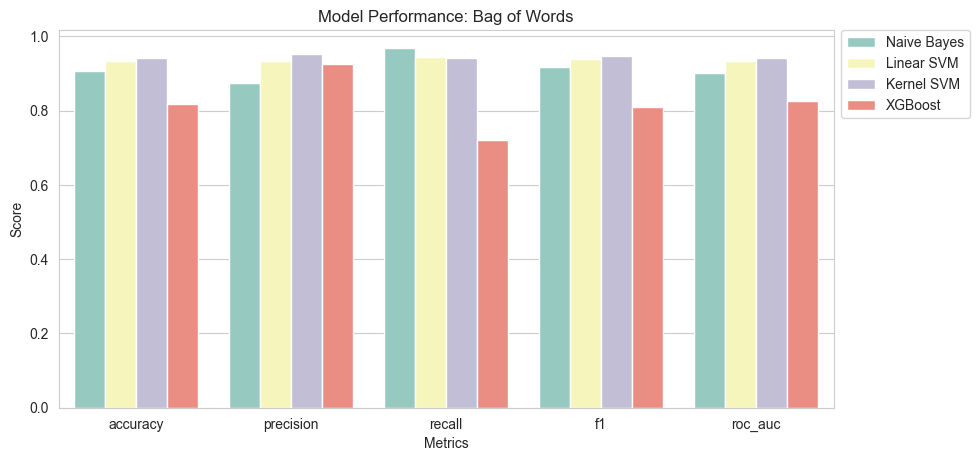

In [27]:
# compare the model performance
# plot the evaluation scores
plt.figure(figsize=(10,5), dpi=100)

chart = sns.barplot(
    data=results_df.melt(id_vars=['metrics'], value_name='Score', var_name='Models'),
    x='metrics',
    y='Score',
    hue='Models',
    palette='Set3'
)

axes = chart.axes
axes.set_title('Model Performance: Bag of Words')
axes.set_xlabel('Metrics')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

In [28]:
# convert the results for TF-IDF into a dataframe
results_df = pd.DataFrame(resultPlotMap['TF-IDF'])
results_df

,metrics,Naive Bayes,Linear SVM,Kernel SVM,XGBoost
0,accuracy,0.910847,0.940801,0.951613,0.816200
1,precision,0.887097,0.946658,0.955950,0.925127
2,recall,0.956679,0.943551,0.954381,0.717755
3,f1,0.920575,0.945102,0.955165,0.808353
4,roc_auc,0.906856,0.940562,0.951372,0.824774


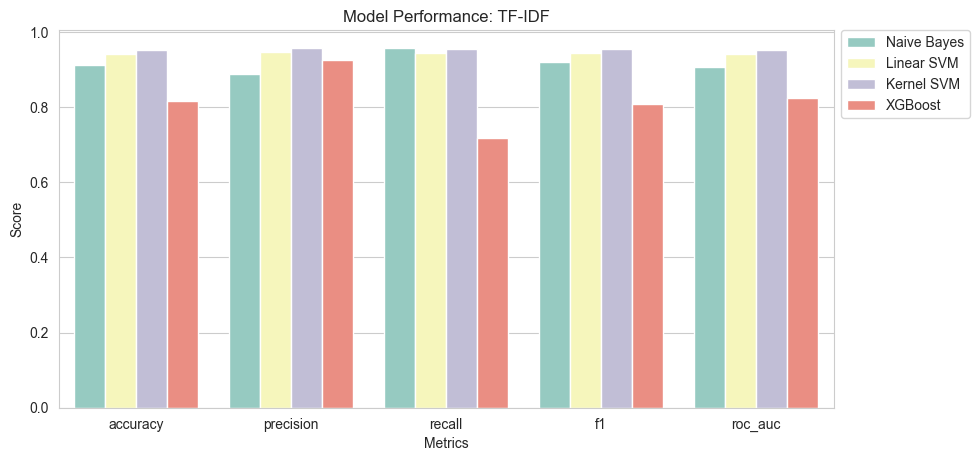

In [33]:
# compare the model performance
# plot the evaluation scores
plt.figure(figsize=(10,5), dpi=100)

chart = sns.barplot(
    data=results_df.melt(id_vars=['metrics'], value_name='Score', var_name='Models'),
    x='metrics',
    y='Score',
    hue='Models',
    palette='Set3'
)

axes = chart.axes
axes.set_title('Model Performance: TF-IDF')
axes.set_xlabel('Metrics')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

In [34]:
# convert the results for Word2Vec into a dataframe
results_df = pd.DataFrame(resultPlotMap['Word2Vec'])
results_df

,metrics,Naive Bayes,Linear SVM,Kernel SVM,XGBoost
0,accuracy,0.660050,0.841546,0.780397,0.825594
1,precision,0.762680,0.908539,0.888316,0.866951
2,recall,0.537906,0.785691,0.678700,0.799803
3,f1,0.630870,0.842661,0.769488,0.832025
4,roc_auc,0.670687,0.846410,0.789254,0.827840


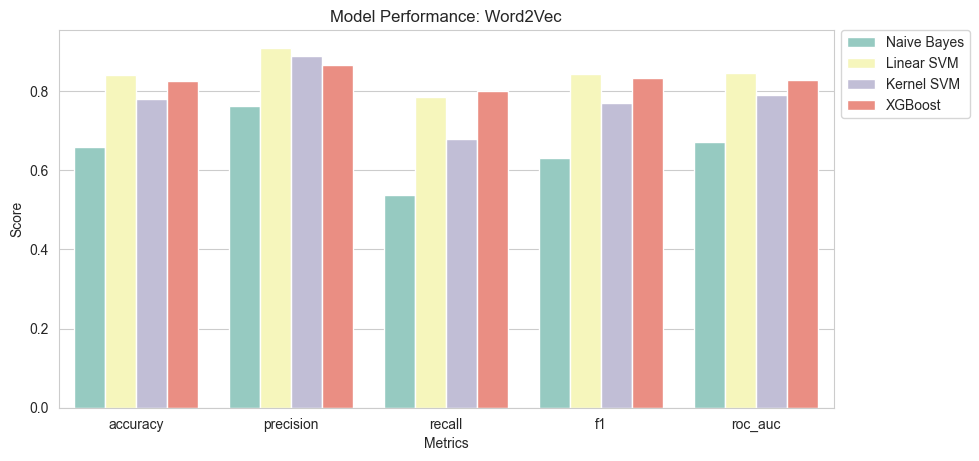

In [35]:
# compare the model performance
# plot the evaluation scores
plt.figure(figsize=(10,5), dpi=100)

chart = sns.barplot(
    data=results_df.melt(id_vars=['metrics'], value_name='Score', var_name='Models'),
    x='metrics',
    y='Score',
    hue='Models',
    palette='Set3'
)

axes = chart.axes
axes.set_title('Model Performance: Word2Vec')
axes.set_xlabel('Metrics')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

In [37]:
# compare the performance of best performing models among each embedding type
results = pd.DataFrame({
    'metrics': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    'Kernel SVM + BoW': [0.942042, 0.951228, 0.940926, 0.946049, 0.942139],
    'Kernel SVM + TF-IDF': [0.951613, 0.955950, 0.954381, 0.955165, 0.951372],
    'Linear SVM + Word2Vec': [0.841546, 0.908539, 0.785691, 0.842661, 0.846410],
})

results

,metrics,Kernel SVM + BoW,Kernel SVM + TF-IDF,Linear SVM + Word2Vec
0,accuracy,0.942042,0.951613,0.841546
1,precision,0.951228,0.955950,0.908539
2,recall,0.940926,0.954381,0.785691
3,f1,0.946049,0.955165,0.842661
4,roc_auc,0.942139,0.951372,0.846410


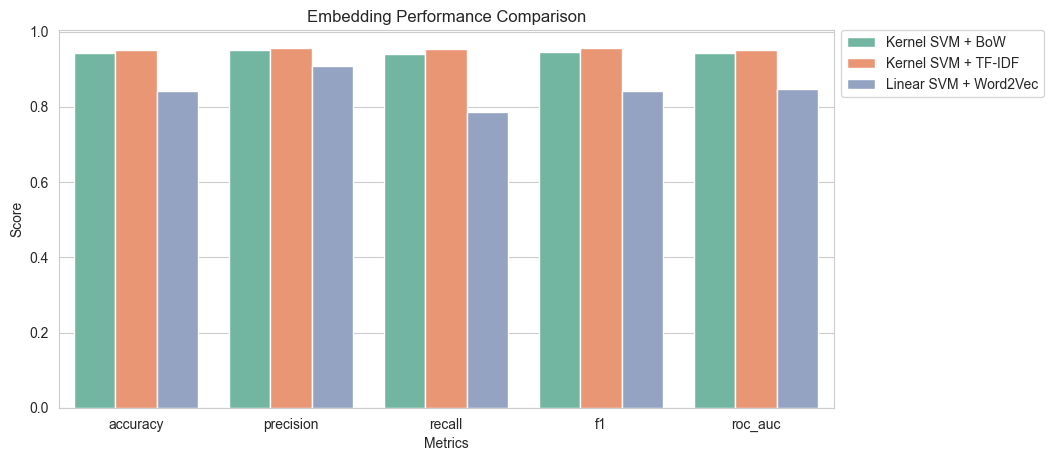

In [41]:
# compare the model performance
# plot the evaluation scores
plt.figure(figsize=(10,5), dpi=100)

chart = sns.barplot(
    data=results.melt(id_vars=['metrics'], value_name='Score', var_name='Models'),
    x='metrics',
    y='Score',
    hue='Models',
    palette='Set2'
)

axes = chart.axes
axes.set_title('Embedding Performance Comparison')
axes.set_xlabel('Metrics')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()